In [1]:
library(ggplot2)
library(igraph)
library(data.table)
library(magrittr)
psize = function(x=10,y=5) { options(repr.plot.width=x, repr.plot.height=y) } 

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Warning message:
“package ‘data.table’ was built under R version 3.6.3”Warning message:
“package ‘magrittr’ was built under R version 3.6.3”

In [2]:
node_dict <- fread(file="../../../data/lookup/node_dict.txt");dim(node_dict); head(node_dict)

[1] 7312    4

old,type,color,new
MHASTHMA,como,#C06C84,asthma
MHCOPD,como,#C06C84,COPD
MHCVD,como,#C06C84,cerebrovascularDiease
MHDPRSSN,como,#C06C84,majorDepression
MHHRTDIS,como,#C06C84,ischemicHeartDisease
MHHTN,como,#C06C84,hyptertension


In [3]:
change_names <- function(dt, lookup, mycol="name"){
  # function to replace names of nodes, using a lookup table
  ## dt: data frame to change
  ## mycol: column in dt to change
  ## lookup table with 'old' and 'new' column, representing old and new names
  dt[, id:=1:nrow(dt)]
  dt <- merge(dt, lookup[,.(old, new)], by.x=mycol, by.y="old", all.x=T)
  dt <- dt[!is.na(new), as.character(mycol):=new][,new:=NULL]
  dt <- dt[order(id)]
  dt[,id:=NULL]
  return(dt)
}

In [6]:
gwas <- fread("data/covid_literature/new_knowing01/Kimono.AnyGWASCovid.nominal.1e-3.simplified.txt", header=F)

In [8]:
gwas[,.N, by=V2]

V2,N
Covid-19 GWAS Hospitalized vs. Non-hospitalized,663
Covid-19 GWAS Very severe vs. Population,515
Covid-19 GWAS Hospitalized vs. Population,475


In [76]:
#covidgenes_negb = read.table("results/covid_net/edgelist/GWAS_meanSim.csv", sep=",", header=TRUE)
covidgenes_negb = read.table("results/covid_net/edgelist/GWAS_meanSim_1e3.csv", sep=",", header=TRUE)

covidgenes_negb$node1 = gsub("GO:", "", covidgenes_negb$node1)
length(unique(covidgenes_negb$node1))

node_name_mapping = read.table("../../../data/lookup/node_name_mapping.txt", sep=",", header=TRUE)
covidgenes_negb <- change_names(as.data.table(covidgenes_negb), as.data.table(node_name_mapping), mycol="node2")
head(covidgenes_negb)


modalities = c("PRS_covid19Severe", "PRS_covid19", "PRS_covid19Hospitalization") 
c_genes <- covidgenes_negb[node2%in% modalities, node1]
table_for_graph  <- covidgenes_negb[node1 %in% c_genes]
table_for_graph <- merge(table_for_graph, node_dict[,.(new, type, color)], by.x="node2", by.y="new", all.x=T)
graph_table <- merge(unique(table_for_graph[,.(node1)]), node_dict[,.(new, type, color)], by.x="node1", by.y="new", all.x=T)
graph_table

[1] 516

node2,X,node1,neighbour,type_node1,type_node2,N,mean_sim,max_sim,sem_sim,source
age,17,ABCA1,1,gene,pheno,100,0.727772,0.772100,0.022543,GWAS
Brain_Amygdala,20,ABCC2,1,gene,tissue,100,0.726440,0.756537,0.015896,GWAS
Spleen,21,ABCC2,1,gene,tissue,100,0.677775,0.737450,0.036785,GWAS
Pituitary,35,ABLIM2,1,gene,tissue,99,0.676106,0.728106,0.023375,GWAS
Esophagus_Muscularis,36,ABLIM2,1,gene,tissue,89,0.664818,0.745099,0.033479,GWAS
Skin_Sun_Exposed_Lower_leg,50,ACAT2,1,gene,tissue,89,0.721932,0.824881,0.053814,GWAS


node1,type,color
ATP5J2,gene,#355C7D
DNMT1,gene,#355C7D
HFE,gene,#355C7D
NCOR2,gene,#355C7D
NR3C1,gene,#355C7D
OSMR,gene,#355C7D
PSMA1,gene,#355C7D
PSMD1,gene,#355C7D
PSMD3,gene,#355C7D
RAD18,gene,#355C7D


## merge back to data source

In [77]:
working_dir = "data/covid_literature/new_knowing01"

gwas_genes = fread(paste0(working_dir,'/Kimono.AnyGWASCovid.nominal.1e-3.simplified.txt'), header=F);head(gwas_genes)

V1,V2
ABCA1,Covid-19 GWAS Hospitalized vs. Non-hospitalized
ABCA1,Covid-19 GWAS Very severe vs. Population
ABCC2,Covid-19 GWAS Hospitalized vs. Non-hospitalized
ABI1,Covid-19 GWAS Very severe vs. Population
ABL1,Covid-19 GWAS Hospitalized vs. Non-hospitalized
ABL2,Covid-19 GWAS Hospitalized vs. Population


In [78]:
graph_table <- merge(graph_table, gwas_genes, by.x="node1", by.y="V1", all.x=T) %>% dplyr::rename(source =V2);
#pal <- c("#274472", "#41729F", "#5885AF", "#C3E0E5")

In [79]:
pal <- c( "#607B8B", "#5885AF", "#C3E0E5")
graph_table$color = "#2E8BC0"
#graph_table$color = pal[as.numeric(as.factor(graph_table$source))]

In [80]:
graph_table

node1,type,color,source
ATP5J2,gene,#2E8BC0,Covid-19 GWAS Hospitalized vs. Population
DNMT1,gene,#2E8BC0,Covid-19 GWAS Very severe vs. Population
HFE,gene,#2E8BC0,Covid-19 GWAS Hospitalized vs. Population
NCOR2,gene,#2E8BC0,Covid-19 GWAS Hospitalized vs. Non-hospitalized
NCOR2,gene,#2E8BC0,Covid-19 GWAS Very severe vs. Population
NR3C1,gene,#2E8BC0,Covid-19 GWAS Hospitalized vs. Non-hospitalized
OSMR,gene,#2E8BC0,Covid-19 GWAS Hospitalized vs. Population
PSMA1,gene,#2E8BC0,Covid-19 GWAS Hospitalized vs. Non-hospitalized
PSMD1,gene,#2E8BC0,Covid-19 GWAS Hospitalized vs. Non-hospitalized
PSMD3,gene,#2E8BC0,Covid-19 GWAS Very severe vs. Population


In [81]:
table_for_graph[node1=="RCHY1"][order(-mean_sim)]

node2,X,node1,neighbour,type_node1,type_node2,N,mean_sim,max_sim,sem_sim,source,type,color
COPD,4101,RCHY1,2,gene,como,100,0.752421,0.800441,0.025222,GWAS,como,#C06C84
PRS_covid19Hospitalization,4102,RCHY1,3,gene,prs,100,0.745009,0.787078,0.017050,GWAS,prs,#F67280
cerebrovascularDiease,4103,RCHY1,1,gene,como,100,0.718671,0.758869,0.016455,GWAS,como,#C06C84
PRS_psoriasis,4104,RCHY1,1,gene,prs,100,0.701638,0.751250,0.020265,GWAS,prs,#F67280
renalFailure,4105,RCHY1,2,gene,como,100,0.697610,0.738084,0.019215,GWAS,como,#C06C84
ischemicHeartDisease,4106,RCHY1,2,gene,como,100,0.685275,0.804876,0.030155,GWAS,como,#C06C84
pneumonia,4107,RCHY1,2,gene,como,100,0.675366,0.708513,0.015285,GWAS,como,#C06C84
liverDisease,4108,RCHY1,2,gene,como,100,0.672801,0.743764,0.034729,GWAS,como,#C06C84
PRS_covid19,4109,RCHY1,2,gene,prs,100,0.667004,0.707179,0.021810,GWAS,prs,#F67280
PRS_heartFailure,4110,RCHY1,1,gene,prs,100,0.662643,0.700341,0.019578,GWAS,prs,#F67280


In [82]:
graph_table[,frame_color:=color]

dup_dt <- graph_table[duplicated(graph_table$node1)]

genes_dt <- graph_table[!duplicated(graph_table$node1)]
genes_dt[node1%in%"NCOR2", frame_color:="#607B8B"]
genes_dt[node1%in%"RAD18", frame_color:="#607B8B"]
graph_table <- genes_dt

In [83]:
leg_dt <- unique(table_for_graph[,.(type, color)])
leg_dt[type=="como", type:="comorbidity"]
leg_dt[type=="prs", type:="PRS"]
leg_dt2 <- as.data.table(rbind(as.data.frame(leg_dt),c("gene",  "#2E8BC0")))
leg_dt2

type,color
tissue,#6C5B7B
comorbidity,#C06C84
PRS,#F67280
gene,#2E8BC0


## plot

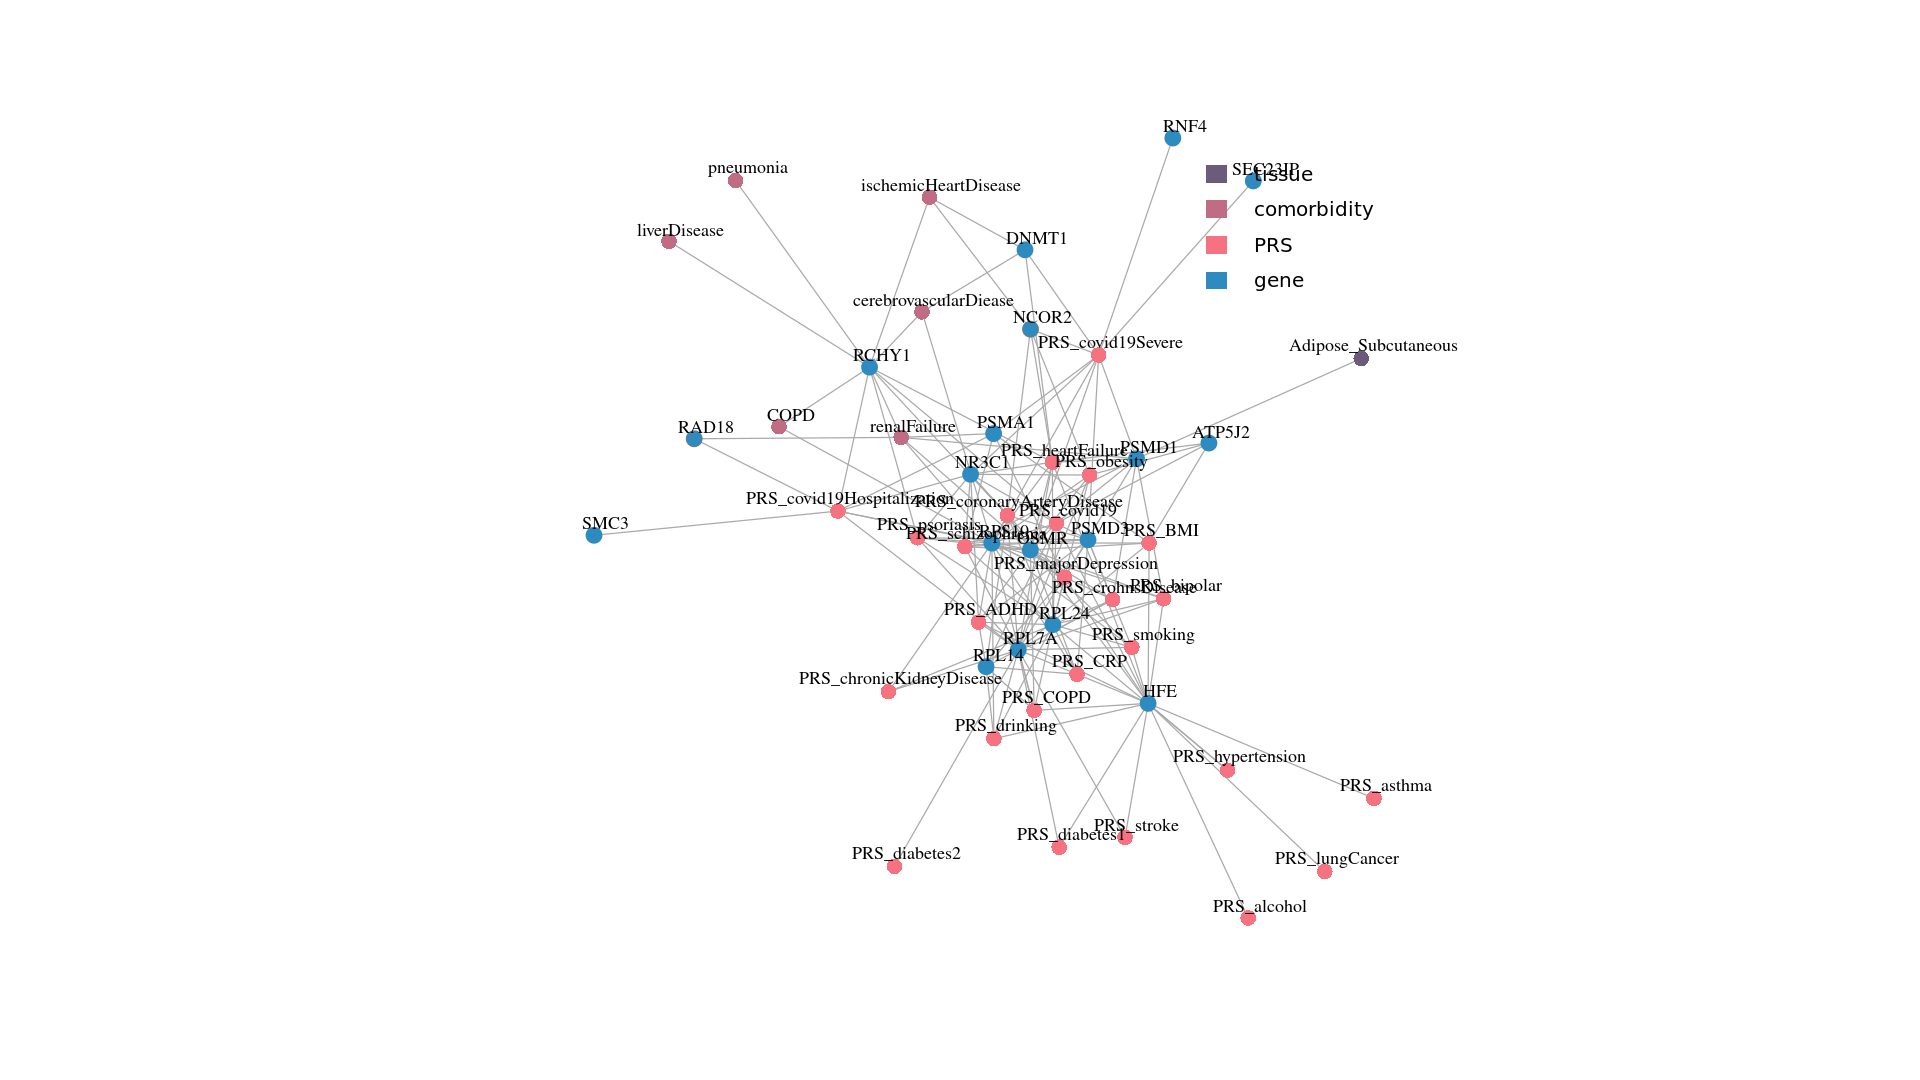

In [84]:
psize(16,9)

g = graph.empty(directed = F)

#g2 = graph.empty(directed = F)

g <- add.vertices(g,nv=length(graph_table$node1)
                  ,attr=list(name=graph_table$node1, color = graph_table$color,
                             frame.color=graph_table$frame_color)
                  ,type=rep(FALSE,length(graph_table$node1)))

dt_other <- unique(table_for_graph[,.(node2, color)])
g <- add.vertices(g,nv=length(dt_other$node2),
                  attr=list(name=as.character(unique(dt_other$node2)), color=dt_other$color),
                  type=rep(TRUE,length(unique(dt_other$node2))))



edges1 = table_for_graph[, .(node1, node2)]
edge.list.vec_1 <- as.vector(t(as.matrix(data.frame(edges1))))


g <- add.edges(g,edge.list.vec_1)

lo = layout_nicely(g, dim = 2)

distances = c(0.6, 0.6)[V(g)$type + 1L]

plot(g, vertex.size = 4, vertex.label.cex = 0.9, vertex.label.color = "black",
        layout = lo,vertex.label.dist=distances)

legend(x = 0.5, y = 1, bty ='n', legend=unique(leg_dt2$type), fill=unique(leg_dt2$color), border=NA)
#legend(x = 0.55, y = 0.9, bty ='n', legend=unique(graph_table$source), fill=unique(graph_table$color), border=NA)


In [87]:
svg(file="results/fig3_covid_net/GWAS_net_1e4_7.svg", width=18, height=18)
psize(16,9)

g = graph.empty(directed = F)

#g2 = graph.empty(directed = F)

g <- add.vertices(g,nv=length(graph_table$node1)
                  ,attr=list(name=graph_table$node1, color = graph_table$color,
                             frame.color=graph_table$frame_color)
                  ,type=rep(FALSE,length(graph_table$node1)))

dt_other <- unique(table_for_graph[,.(node2, color)])
g <- add.vertices(g,nv=length(dt_other$node2),
                  attr=list(name=as.character(unique(dt_other$node2)), color=dt_other$color),
                  type=rep(TRUE,length(unique(dt_other$node2))))



edges1 = table_for_graph[, .(node1, node2)]
edge.list.vec_1 <- as.vector(t(as.matrix(data.frame(edges1))))


g <- add.edges(g,edge.list.vec_1)

lo = layout_nicely(g, dim = 2)

distances = c(0.6, 0.6)[V(g)$type + 1L]

plot(g, vertex.size = 4, vertex.label.cex = 0.9, vertex.label.color = "black",
        layout = lo,vertex.label.dist=distances)

legend(x = 0.5, y = 1, bty ='n', legend=unique(leg_dt2$type), fill=unique(leg_dt2$color), border=NA)
#legend(x = 0.55, y = 0.9, bty ='n', legend=unique(graph_table$source), fill=unique(graph_table$color), border=NA)


dev.off()

png 
  2

In [ ]:
pdf(file="results/fig3_covid_net/GWAS_net_1e3.pdf", width=18, height=18)
psize(16,9)

g = graph.empty(directed = F)

#g2 = graph.empty(directed = F)

g <- add.vertices(g,nv=length(graph_table$node1)
                  ,attr=list(name=graph_table$node1, color = graph_table$color,
                             frame.color=graph_table$frame_color)
                  ,type=rep(FALSE,length(graph_table$node1)))

dt_other <- unique(table_for_graph[,.(node2, color)])
g <- add.vertices(g,nv=length(dt_other$node2),
                  attr=list(name=as.character(unique(dt_other$node2)), color=dt_other$color),
                  type=rep(TRUE,length(unique(dt_other$node2))))



edges1 = table_for_graph[, .(node1, node2)]
edge.list.vec_1 <- as.vector(t(as.matrix(data.frame(edges1))))


g <- add.edges(g,edge.list.vec_1)

lo = layout_nicely(g, dim = 2)

distances = c(0.6, 0.6)[V(g)$type + 1L]

plot(g, vertex.size = 4, vertex.label.cex = 0.9, vertex.label.color = "black",
        layout = lo,vertex.label.dist=distances)

legend(x = 0.5, y = 1, bty ='n', legend=unique(leg_dt2$type), fill=unique(leg_dt2$color), border=NA)
legend(x = 0.55, y = 0.85, bty ='n', legend=unique(graph_table$source), fill=unique(graph_table$color), border=NA)


dev.off()

In [ ]:
study="GWAS"
context <- covidgenes_negb[,.N, by=.(node2, type_node2)][order(-N)]
dt = context[type_node2=="pheno"] %>% dplyr::rename(node=node2, type=type_node2, count=N)
all=sum(dt$count)
dt[,ratio:=count/all]
fwrite(dt, file=paste0("results/fig3_supp_net_context/",study, "_pheno_dt.csv"))
dt=context[type_node2=="como"] %>% dplyr::rename(node=node2,  type=type_node2,count=N)
all=sum(dt$count)
dt[,ratio:=count/all]
fwrite(dt, file=paste0("results/fig3_supp_net_context/",study, "_como_dt.csv"))
dt=context[type_node2=="prs"] %>% dplyr::rename(node=node2,  type=type_node2,count=N)
all=sum(dt$count)
dt[,ratio:=count/all]
fwrite(dt, file=paste0("results/fig3_supp_net_context/",study, "_prs_dt.csv"))
dt=context[type_node2=="tissue"]%>% dplyr::rename(node=node2,  type=type_node2,count=N)
all=sum(dt$count)
dt[,ratio:=count/all]
fwrite(dt, file=paste0("results/fig3_supp_net_context/",study, "_tissue_dt.csv"))


gene_source=graph_table[,.(node1, source)] %>% dplyr::rename(gene=node1)
fwrite(gene_source[order(gene)], file=paste0("results/fig3_supp_net_context/",study, "_gene_source.csv"))